# Download Cora dataset

In [57]:
import torch
import os.path as osp
from torch_geometric.datasets import Planetoid

# Define the path to the dataset directory
path = osp.join('data', 'Cora')

# Load the Cora dataset using the Planetoid class
dataset = Planetoid(path, name='Cora')
data = dataset[0]

# Extract node features, edge index, and labels
node_features = data.x  # (number_of_nodes, number_of_features)
edge_index = data.edge_index  # (2, number_of_edges)
labels = data.y  # (number_of_nodes,)

print(f"Node Features Shape: {node_features.shape}")
print(f"Edge Index Shape: {edge_index.shape}")
print(f"Labels Shape: {labels.shape}")


Node Features Shape: torch.Size([2708, 1433])
Edge Index Shape: torch.Size([2, 10556])
Labels Shape: torch.Size([2708])


Processing...
Done!


# 1. GraphSAGE

## 1.1. Create an Adjacency List and Feature Dictionary

In [58]:
from collections import defaultdict
import numpy as np

# Create adjacency list from edge_index
def build_adj_list(edge_index):
    adj_list = defaultdict(list)
    for i, j in edge_index.t().tolist():
        adj_list[i].append(j)
        adj_list[j].append(i)  # Since it's an undirected graph
    return adj_list

adj_list = build_adj_list(edge_index)

# Convert node features to a dictionary
node_features_dict = {i: node_features[i].numpy() for i in range(node_features.shape[0])}

# Check adjacency list and node features
print("Adjacency List Example (Node 0):", adj_list[0])
print("Node Features Example (Node 0):", node_features_dict[0])


Adjacency List Example (Node 0): [633, 1862, 2582, 633, 1862, 2582]
Node Features Example (Node 0): [0. 0. 0. ... 0. 0. 0.]


## 1.2. Random Sampling of Neighbors

In [78]:
import random

def sample_neighbors(adj_list, node, sample_size):
    """Sample neighbors of a node randomly."""
    neighbors = adj_list.get(node, [])  # Get neighbors or empty list if node has no neighbors
    if len(neighbors) == 0:
        return []  # No neighbors, return empty list
    elif len(neighbors) <= sample_size:
        return neighbors  # Return all neighbors if fewer than sample size
    else:
        return random.sample(neighbors, sample_size)  # Randomly sample neighbors without replacement

# Example: Sample neighbors for node 0
sampled_neighbors = sample_neighbors(adj_list, 0, sample_size=5)
print("Sampled Neighbors for Node 0:", sampled_neighbors)


Sampled Neighbors for Node 0: [633, 2582, 1862, 1862, 2582]


## 1.3. Feature Aggregation

In [61]:
def aggregate_features(node, sampled_neighbors, node_features_dict):
    if len(sampled_neighbors) == 0:
        return np.zeros_like(node_features_dict[node])
    neighbor_features = np.array([node_features_dict[neighbor] for neighbor in sampled_neighbors])
    aggregated_features = np.mean(neighbor_features, axis=0)
    return aggregated_features

# Example: Aggregate features for node 0
aggregated_features_0 = aggregate_features(0, sampled_neighbors, node_features_dict)
print("Aggregated Features for Node 0:", aggregated_features_0)


Aggregated Features for Node 0: [0.  0.  0.  ... 0.  0.4 0. ]


## 1.4. Update Node Representation

In [63]:
def update_node_representation(node, aggregated_features, node_features_dict, weight_matrix):
    # Get the node's feature vector
    node_feature = node_features_dict[node]
    
    # Concatenate the node's feature and the aggregated neighbor features
    concatenated_features = np.concatenate([node_feature, aggregated_features])  # Shape: (2 * input_dim,)
    
    # Perform matrix multiplication: weight_matrix * concatenated_features
    updated_representation = np.dot(weight_matrix, concatenated_features)  # weight_matrix shape: (input_dim, 2 * input_dim)
    
    return updated_representation

# Example: Initialize a weight matrix and update node representation for node 0
input_dim = node_features.shape[1]  # Cora feature dimension is 1433
weight_matrix = np.random.rand(input_dim, 2 * input_dim)  # Shape: (input_dim, 2 * input_dim)

# Assuming we already aggregated features for node 0 using the previous steps
updated_representation_0 = update_node_representation(0, aggregated_features_0, node_features_dict, weight_matrix)
print("Updated Representation for Node 0:", updated_representation_0)


Updated Representation for Node 0: [12.84879872 11.98199988 16.33841434 ... 13.20789477 13.29756926
 12.96612198]


## 1.5. GraphSAGE Layer

In [64]:
def graphsage_layer(adj_list, node_features_dict, sample_size, weight_matrix):
    new_node_features_dict = {}
    for node in node_features_dict:
        sampled_neighbors = sample_neighbors(adj_list, node, sample_size)
        aggregated_features = aggregate_features(node, sampled_neighbors, node_features_dict)
        updated_representation = update_node_representation(node, aggregated_features, node_features_dict, weight_matrix)
        new_node_features_dict[node] = updated_representation
    return new_node_features_dict

# Example: Apply one layer of GraphSAGE
new_node_features_dict = graphsage_layer(adj_list, node_features_dict, sample_size=5, weight_matrix=weight_matrix)
print("New Node Representation for Node 0:", new_node_features_dict[0])


New Node Representation for Node 0: [12.8718061  12.05909992 15.97781065 ... 13.00685744 12.93621315
 13.04651281]


## 1.6. Two-Layer GraphSAGE

In [134]:
def multilayer_graphsage(adj_list, node_features_dict, num_layers, sample_size):
    """Apply multiple layers of GraphSAGE."""
    input_dim = len(next(iter(node_features_dict.values())))  # Get the feature dimension from any node
    current_node_features_dict = node_features_dict
    
    for layer in range(num_layers):
        # Correct weight matrix shape: (input_dim, 2 * input_dim)
        weight_matrix = np.random.rand(input_dim, 2 * input_dim)
        
        # Apply one GraphSAGE layer
        current_node_features_dict = graphsage_layer(adj_list, current_node_features_dict, sample_size, weight_matrix)
    
    return current_node_features_dict

# Example: Apply 2 layers of GraphSAGE
final_node_features_dict = multilayer_graphsage(adj_list, node_features_dict, num_layers=2, sample_size=5)

# Print the final representation of node 0 after 2 layers
print("Final Node Representation for Node 0 after 2 layers:", final_node_features_dict[0])

Final Node Representation for Node 0 after 2 layers: [21631.70786459 21468.99100714 21466.0180551  ... 21681.56553095
 21624.08003047 21730.56945829]


## 1.7 Regression task 

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Extract node features and labels based on the correct node IDs
node_ids = list(final_node_features_dict.keys())  # Get the list of node IDs from the final_node_features dict
X = np.array([final_node_features_dict[node] for node in node_ids])  # Extract the corresponding node features
y = np.array([labels[node] for node in node_ids])  # Extract the corresponding labels for these nodes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression(solver='liblinear',max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 84.32%


## 1.8 t-SNE víualization

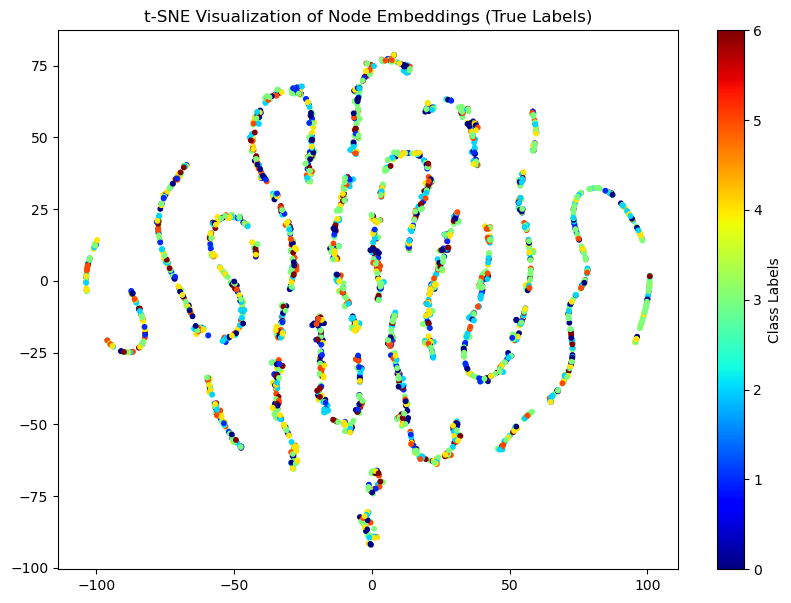

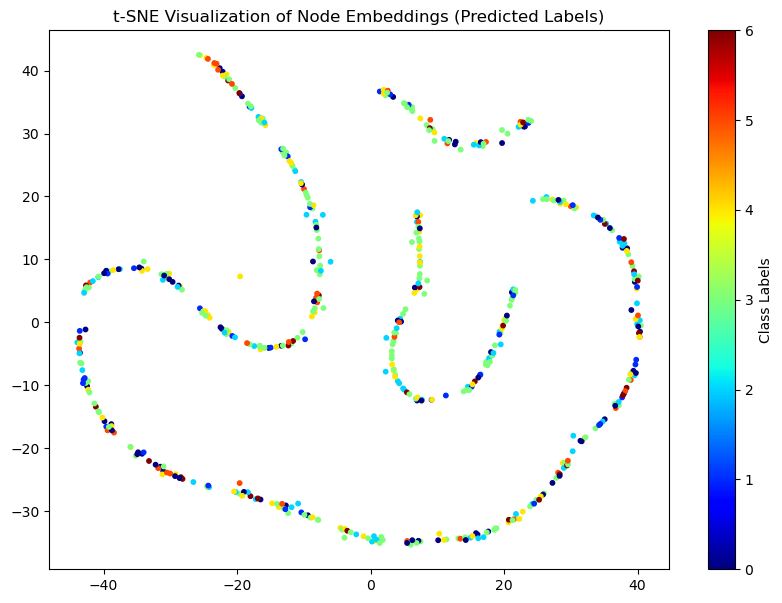

In [139]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions of node embeddings using t-SNE
def visualize_tsne(X, y, title, perplexity=10):
    """Visualize embeddings using t-SNE."""
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(perplexity, X.shape[0] - 1))
    X_tsne = tsne.fit_transform(X)

    # Plot t-SNE results
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='jet', s=10)
    plt.colorbar(scatter, label='Class Labels')
    plt.title(title)
    plt.show()

# Visualize node embeddings with true labels
visualize_tsne(X, y, "t-SNE Visualization of Node Embeddings (True Labels)")

# Visualize node embeddings with predicted labels
visualize_tsne(X_test, y_pred, "t-SNE Visualization of Node Embeddings (Predicted Labels)")


# 2. GraphSAINT

In [79]:
import torch
import os.path as osp
from torch_geometric.datasets import Planetoid
import numpy as np

# Define the path to the dataset directory
path = osp.join('data', 'Cora')

# Load the Cora dataset using the Planetoid class
dataset = Planetoid(path, name='Cora')
data = dataset[0]

# Extract node features, edge index, and labels
node_features = data.x.numpy()  # (number_of_nodes, number_of_features)
edge_index = data.edge_index.numpy()  # (2, number_of_edges)
labels = data.y.numpy()  # (number_of_nodes,)

print(f"Node Features Shape: {node_features.shape}")
print(f"Edge Index Shape: {edge_index.shape}")
print(f"Labels Shape: {labels.shape}")


Node Features Shape: (2708, 1433)
Edge Index Shape: (2, 10556)
Labels Shape: (2708,)


## 2.1. Sampling Subgraphs (Node Sampling)

In [80]:
import random
from collections import defaultdict

def sample_subgraph(adj_list, node_features, sample_size):
    """Sample a subgraph by randomly selecting a subset of nodes."""
    nodes = list(node_features.keys())
    sampled_nodes = random.sample(nodes, sample_size)  # Sample a subset of nodes
    
    # Induce the subgraph by selecting edges within the sampled nodes
    sampled_adj_list = defaultdict(list)
    for node in sampled_nodes:
        neighbors = adj_list[node]
        sampled_adj_list[node] = [n for n in neighbors if n in sampled_nodes]
    
    # Extract subgraph features and labels
    sampled_features = {node: node_features[node] for node in sampled_nodes}
    
    return sampled_adj_list, sampled_features, sampled_nodes

# Build the adjacency list
def build_adj_list(edge_index):
    adj_list = defaultdict(list)
    for i, j in edge_index.T:
        adj_list[i].append(j)
        adj_list[j].append(i)  # Since it's an undirected graph
    return adj_list

adj_list = build_adj_list(edge_index)

# Convert node features to dictionary format
node_features_dict = {i: node_features[i] for i in range(node_features.shape[0])}

# Example: Sample a subgraph
sampled_adj_list, sampled_features, sampled_nodes = sample_subgraph(adj_list, node_features_dict, sample_size=100)

# Check sampled subgraph
print(f"Sampled Nodes: {sampled_nodes}")
print(f"Sampled Adjacency List (first 5 nodes): {list(sampled_adj_list.items())[:5]}")


Sampled Nodes: [1142, 1848, 700, 2176, 258, 630, 287, 2628, 1206, 1270, 1562, 730, 727, 1770, 1723, 2590, 491, 880, 283, 132, 1443, 634, 1140, 1195, 1434, 176, 1086, 2644, 255, 2451, 2461, 1749, 240, 1472, 2032, 1761, 2637, 2398, 715, 962, 1689, 1568, 151, 1597, 933, 695, 955, 608, 1431, 2205, 125, 1062, 1944, 1052, 1673, 252, 161, 1878, 744, 331, 1634, 1923, 845, 1361, 742, 506, 1968, 1387, 802, 119, 533, 2277, 2134, 1176, 380, 1261, 2263, 1789, 1764, 145, 666, 732, 780, 1659, 1894, 430, 436, 1212, 2412, 2315, 2408, 2175, 994, 843, 327, 1963, 2372, 1421, 598, 1937]
Sampled Adjacency List (first 5 nodes): [(1142, []), (1848, []), (700, []), (2176, [2175, 2175]), (258, [])]


## 2.2. Mini-batch Training

In [81]:
def create_mini_batches(adj_list, node_features_dict, batch_size, num_batches):
    """Create mini-batches by sampling multiple subgraphs."""
    mini_batches = []
    for _ in range(num_batches):
        sampled_adj_list, sampled_features, sampled_nodes = sample_subgraph(adj_list, node_features_dict, batch_size)
        mini_batches.append((sampled_adj_list, sampled_features, sampled_nodes))
    return mini_batches

# Example: Create 5 mini-batches, each with 100 nodes
mini_batches = create_mini_batches(adj_list, node_features_dict, batch_size=100, num_batches=5)

# Check the first mini-batch
print(f"Mini-batch 1: {mini_batches[0]}")


Mini-batch 1: (defaultdict(<class 'list'>, {1581: [], 587: [], 1033: [173, 173], 1154: [], 2561: [], 1386: [], 57: [], 236: [], 2216: [1724, 2212, 1724, 2212], 2404: [], 1963: [1022, 1022], 1809: [], 2320: [1681, 1681], 782: [], 2364: [], 618: [], 1229: [], 1277: [], 905: [], 1578: [], 1999: [], 1894: [], 632: [], 813: [], 2141: [], 2282: [], 1918: [], 1424: [], 2646: [], 1753: [], 604: [], 2017: [2467, 2467], 1564: [], 321: [], 2467: [2017, 2017], 98: [], 1990: [], 1681: [2320, 2320], 195: [], 2437: [], 2019: [], 868: [], 2505: [], 758: [], 1310: [], 848: [], 1206: [], 688: [], 2329: [], 835: [], 1311: [], 2634: [], 1234: [], 52: [], 539: [], 647: [], 841: [], 1944: [], 1485: [], 2068: [], 1376: [], 1926: [], 385: [], 1940: [], 1729: [], 2067: [], 1332: [], 1237: [], 2212: [2216, 2216], 1022: [1963, 1963], 178: [], 187: [], 1734: [], 1594: [], 1288: [], 304: [], 916: [], 2403: [], 2475: [], 1069: [], 173: [1033, 1033], 713: [], 360: [], 1924: [], 2703: [], 83: [], 1323: [], 1724: [221

## 2.3. GCN layer

In [84]:
def gnn_layer(adj_list, node_features, weight_matrix):
    """Apply a simplified GCN layer (feature aggregation + weight transformation)."""
    new_node_features = {}
    for node in node_features:
        neighbors = adj_list[node]
        if len(neighbors) == 0:
            neighbor_features = np.zeros_like(node_features[node])
        else:
            neighbor_features = np.mean([node_features[n] for n in neighbors], axis=0)
        
        # Concatenate the node's own features with its neighbors' aggregated features
        aggregated_features = np.concatenate([node_features[node], neighbor_features])  # Shape: (2 * input_dim,)
        
        # Apply a linear transformation (weight matrix)
        # Weight matrix shape should be (input_dim, 2 * input_dim) to align with the concatenated features
        new_representation = np.dot(weight_matrix, aggregated_features)  # weight_matrix shape: (input_dim, 2 * input_dim)
        new_node_features[node] = new_representation
    return new_node_features

# Example: Apply a single GNN layer on a sampled mini-batch
input_dim = node_features.shape[1]  # The feature dimension of nodes (e.g., 1433 for Cora)
output_dim = input_dim  # Can choose a different dimension for the output

# Initialize the weight matrix to have shape (input_dim, 2 * input_dim)
weight_matrix = np.random.rand(output_dim, input_dim * 2)

# Apply the GNN layer on a mini-batch
sampled_adj_list, sampled_features, sampled_nodes = mini_batches[0]
new_node_features = gnn_layer(sampled_adj_list, sampled_features, weight_matrix)

# Check the new node representation
print(f"New Node Representation for a sampled node: {new_node_features[sampled_nodes[0]]}")

New Node Representation for a sampled node: [ 9.87428441 11.19325543  9.11514725 ...  8.44257904  7.72657621
 10.84055993]


## 2.4. Two-layer GraphSAINT

In [88]:
import numpy as np

def gnn_layer(adj_list, node_features, weight_matrix):
    """Apply a simplified GCN layer (feature aggregation + weight transformation)."""
    new_node_features = {}
    for node in node_features:
        neighbors = adj_list[node]
        if len(neighbors) == 0:
            neighbor_features = np.zeros_like(node_features[node])
        else:
            neighbor_features = np.mean([node_features[n] for n in neighbors], axis=0)
        
        # Concatenate the node's own features with its neighbors' aggregated features
        aggregated_features = np.concatenate([node_features[node], neighbor_features])  # Shape: (2 * input_dim,)
        
        # Apply a linear transformation (weight matrix)
        new_representation = np.dot(weight_matrix, aggregated_features)  # weight_matrix shape: (output_dim, 2 * input_dim)
        new_node_features[node] = new_representation
    return new_node_features

def two_layer_graphsaint(mini_batches, input_dim, hidden_dim):
    """Apply two GNN layers to update node representations."""
    # Initialize weight matrices for both layers
    weight_matrix_1 = np.random.rand(hidden_dim, 2 * input_dim)  # First layer weight matrix: (hidden_dim, 2 * input_dim)
    weight_matrix_2 = np.random.rand(hidden_dim, 2 * hidden_dim)  # Second layer weight matrix: (hidden_dim, 2 * hidden_dim)
    
    for batch in mini_batches:
        sampled_adj_list, sampled_features, sampled_nodes = batch
        
        # Apply first GNN layer
        node_features_layer1 = gnn_layer(sampled_adj_list, sampled_features, weight_matrix_1)
        
        # Apply second GNN layer
        node_features_layer2 = gnn_layer(sampled_adj_list, node_features_layer1, weight_matrix_2)
        
        # Update the node features
        final_node_features = node_features_layer2
        
        return final_node_features

# Example: Apply 2-layer GraphSAINT
hidden_dim = 64  # Hidden dimension size
final_node_features = two_layer_graphsaint(mini_batches, input_dim=input_dim, hidden_dim=hidden_dim)

# Check final node representation for a sampled node
print(f"Final Node Representation for a sampled node: {final_node_features[sampled_nodes[0]]}")

Final Node Representation for a sampled node: [284.92022152 293.70490255 314.4998094  299.85550603 279.69766917
 256.51571006 274.50271013 280.68002389 279.8110918  319.03258504
 287.71022203 305.82333215 269.73197226 290.28459997 304.3128423
 276.50295903 315.63489096 311.17991719 302.57466455 293.89909065
 282.37960257 293.33704465 290.26030764 302.6699815  310.25128218
 293.96756884 310.43926806 292.99328175 298.1102592  317.79204957
 289.17115008 309.31609917 284.00557161 298.95188908 270.00648181
 299.40223293 276.51323598 267.59213876 287.46503972 307.34837695
 251.05400792 324.0027296  315.51520125 249.6290558  299.91186996
 263.88492779 264.1227215  265.71644882 323.22041756 324.07544784
 263.10921686 291.06990347 282.64075103 306.51055249 319.31469485
 267.30165802 314.10091648 262.4937435  284.5761308  269.2143965
 298.70416034 313.21941374 285.38774848 261.3363257 ]


## 2.5. GraphSAINT with Cora dataset

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Extract node features and labels based on the correct node IDs
node_ids = list(final_node_features.keys())  # Get the list of node IDs from the final_node_features dict
X = np.array([final_node_features[node] for node in node_ids])  # Extract the corresponding node features
y = np.array([labels[node] for node in node_ids])  # Extract the corresponding labels for these nodes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression(solver='liblinear', max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 30.00%


## 2.6. t-SNE visualization

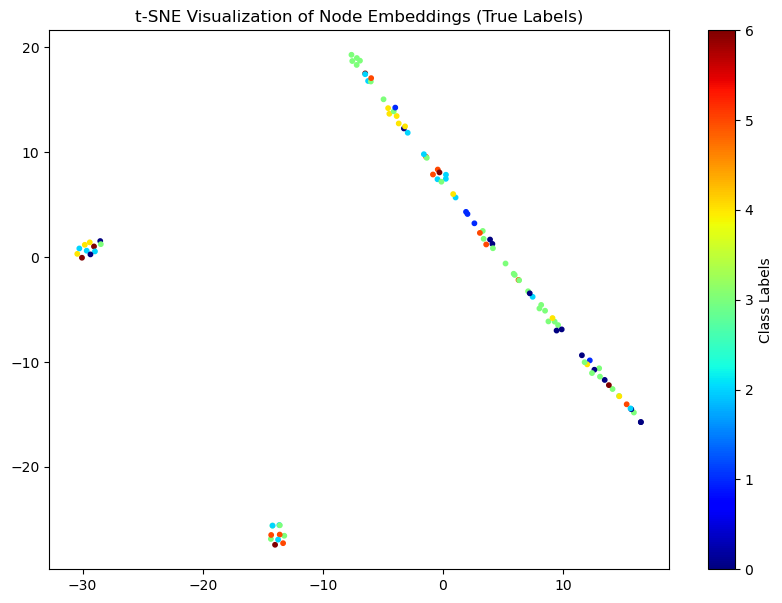

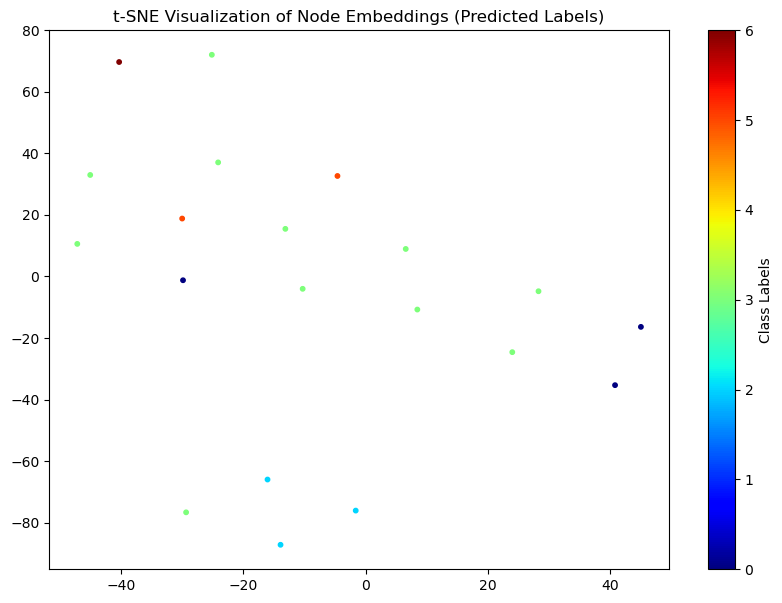

In [95]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions of node embeddings using t-SNE
def visualize_tsne(X, y, title, perplexity=10):
    """Visualize embeddings using t-SNE."""
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(perplexity, X.shape[0] - 1))
    X_tsne = tsne.fit_transform(X)

    # Plot t-SNE results
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='jet', s=10)
    plt.colorbar(scatter, label='Class Labels')
    plt.title(title)
    plt.show()

# Visualize node embeddings with true labels
visualize_tsne(X, y, "t-SNE Visualization of Node Embeddings (True Labels)")

# Visualize node embeddings with predicted labels
visualize_tsne(X_test, y_pred, "t-SNE Visualization of Node Embeddings (Predicted Labels)")


# 3. ClusterGCN

In [97]:
import torch
import os.path as osp
from torch_geometric.datasets import Planetoid

# Define the path to the dataset directory
path = osp.join('data', 'Cora')

# Load the Cora dataset using the Planetoid class
dataset = Planetoid(path, name='Cora')
data = dataset[0]

# Extract node features, edge index, and labels
node_features = data.x  # (number_of_nodes, number_of_features)
edge_index = data.edge_index  # (2, number_of_edges)
labels = data.y  # (number_of_nodes,)

print(f"Node Features Shape: {node_features.shape}")
print(f"Edge Index Shape: {edge_index.shape}")
print(f"Labels Shape: {labels.shape}")


Node Features Shape: torch.Size([2708, 1433])
Edge Index Shape: torch.Size([2, 10556])
Labels Shape: torch.Size([2708])


## 3.1. Build clusters and batch the data

In [121]:
def build_clusters(edge_index, num_clusters):
    num_nodes = node_features.shape[0]
    cluster_size = num_nodes // num_clusters
    clusters = []
    nodes = np.arange(num_nodes)
    np.random.shuffle(nodes)
    for i in range(num_clusters):
        if i == num_clusters - 1:
            clusters.append(nodes[i * cluster_size:])
        else:
            clusters.append(nodes[i * cluster_size: (i + 1) * cluster_size])
    return clusters

## 3.2. Define function to extract subgraph for a specific cluster

In [122]:
def extract_subgraph(edge_index, cluster):
    mask = np.isin(edge_index[0].numpy(), cluster) & np.isin(edge_index[1].numpy(), cluster)
    sub_edge_index = edge_index[:, mask]
    node_map = {node: i for i, node in enumerate(cluster)}
    sub_edge_index = torch.tensor([[node_map[n.item()] for n in sub_edge_index[0]],
                                   [node_map[n.item()] for n in sub_edge_index[1]]])
    return sub_edge_index

## 3.3. Batch construction with clusters

In [123]:
def construct_batch(clusters, edge_index):
    batch_node_features = []
    batch_edge_index = []
    batch_labels = []
    for cluster in clusters:
        subgraph_edges = extract_subgraph(edge_index, cluster)
        subgraph_features = node_features[cluster]
        subgraph_labels = labels[cluster]
        batch_node_features.append(subgraph_features)
        batch_edge_index.append(subgraph_edges)
        batch_labels.append(subgraph_labels)
    return batch_node_features, batch_edge_index, batch_labels


## 3.4. Define ClusterGCNLayer

In [124]:
class ClusterGCNLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(ClusterGCNLayer, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)

    def forward(self, node_features, edge_index):
        # Simplified message passing (GCN layer operation)
        row, col = edge_index
        aggregate = torch.zeros_like(node_features)
        
        for i in range(len(row)):
            aggregate[row[i]] += node_features[col[i]]
        
        return self.linear(aggregate)

## 3.5. Define ClusterGCN model

In [125]:
class ClusterGCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(ClusterGCN, self).__init__()
        self.layer1 = ClusterGCNLayer(in_features, hidden_features)
        self.layer2 = ClusterGCNLayer(hidden_features, out_features)

    def forward(self, batch_node_features, batch_edge_index):
        # Process each cluster
        out = []
        for node_features, edge_index in zip(batch_node_features, batch_edge_index):
            x = self.layer1(node_features, edge_index)
            x = torch.relu(x)
            x = self.layer2(x, edge_index)
            out.append(x)
        
        return out

## 3.6. Train ClusterGCN

In [126]:
import torch.optim as optim
import torch.nn as nn

# Define number of clusters
num_clusters = 10
clusters = build_clusters(edge_index, num_clusters)
batch_node_features, batch_edge_index, batch_labels = construct_batch(clusters, edge_index)

# Step 2: Train the ClusterGCN model
def train_cluster_gcn(node_features, edge_index, labels):
    all_labels = torch.cat(labels, dim=0)
    model = ClusterGCN(node_features[0].shape[1], 16, len(torch.unique(all_labels)))
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(node_features, edge_index)
        all_outputs = torch.cat(outputs, dim=0)
        loss = loss_fn(all_outputs, all_labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    return model

# Train the model
model = train_cluster_gcn(batch_node_features, batch_edge_index, batch_labels)


Epoch 10, Loss: 1.6173955202102661
Epoch 20, Loss: 1.4217066764831543
Epoch 30, Loss: 1.3526371717453003
Epoch 40, Loss: 1.3278746604919434
Epoch 50, Loss: 1.3165616989135742


## 3.7. Extract node embedding after training

In [127]:
def get_node_embeddings(model, batch_node_features, batch_edge_index):
    model.eval()
    embeddings = []
    with torch.no_grad():
        outputs = model(batch_node_features, batch_edge_index)
        embeddings = torch.cat(outputs, dim=0)
    return embeddings

# Get the trained node embeddings
node_embeddings = get_node_embeddings(model, batch_node_features, batch_edge_index)

# Ensure embeddings are on CPU for t-SNE
node_embeddings = node_embeddings.cpu()


## 3.8. Visualization

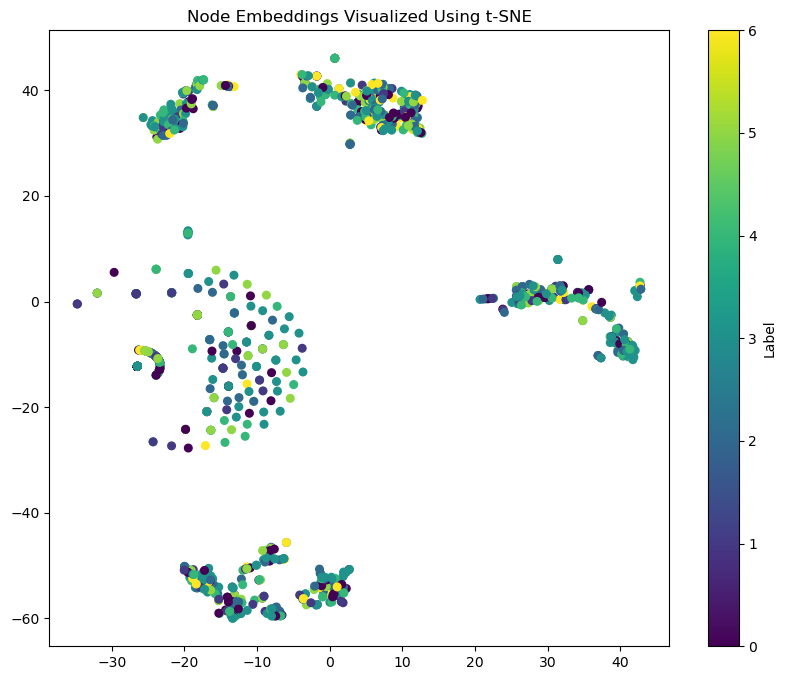

In [128]:
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Step 5: Plot the embeddings, coloring them by their true labels
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=labels.numpy(), cmap='viridis', s=30)
plt.colorbar(label="Label")
plt.title('Node Embeddings Visualized Using t-SNE')
plt.show()